# Analytathon 2 - Bird Song Recognization
Acoustic recordings of bird songs can be used to monitor bird species in a region. It is difficult for experts to analyse the presence of specific bird species by listening to these recordings. You will address this challenge by developing computational tools to automatically classify and 
cluster bird songs to detect the presence of various species in the wild based on their recordings. Bird song recordings were sourced from the citizen science website xeno_canto, which provides audio files of bird songs from around the world. 

## Goal 1: Build a model to classify the bird audio clips

### Q1: How will you split the data into test and training sets?
### Q2: What is the most appropriate model for the problem?
### Q3: What level of performance is good enough to be useful?

In [380]:
# Importing the libraries

import os
import numpy as np
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import  DataLoader
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [381]:
# setting seed

torch.manual_seed(99)
np.random.seed(99)

In [382]:
# Directory containing the images
greypatridgespec = 'D:/college/8023/Analytathon 2/code/Goal1/greypartridgespec'
stockdovespec= 'D:/college/8023/Analytathon 2/code/Goal1/stockdovespec'
turtledovespec='D:/college/8023/Analytathon 2/code/Goal1/turtledovespec'
yellowhammerspec='D:/college/8023/Analytathon 2/code/Goal1/yellowhammerspec'

# List of all image file names in the directory
img_files_grey = os.listdir(greypatridgespec)
img_files_stock = os.listdir(stockdovespec)
img_files_turtle = os.listdir(turtledovespec)
img_files_yellow = os.listdir(yellowhammerspec)

classes=['greypatridgespec','stockdovespec','turtledovespec','yellowhammerspeck']



In [383]:
# Image resizer function

import cv2


def imageResizer(img):
    # target_height = 128
    # target_width = 216
    # width, height = img.size

    # if width > height:
    #     new_width = target_width
    #     new_height = int(height * (target_width / width))
    # else:
    #     new_width = int(width * (target_height / height))
    #     new_height = target_height

    # img = img.resize((new_width, new_height), Image.ANTIALIAS)

    # new_img = Image.new('L', (target_width, target_height),0)
    
    # left = int((target_width - new_width) / 2)
    # top = int((target_height - new_height) / 2)
    # new_img.paste(img, (left, top))
    new_img =cv2.resize(img,(128,128))
    
    return new_img

In [384]:
# Image reader function

def imageReader(image_list,file_path,label_name):
    data=[]
    for i,file_name in enumerate(image_list):
    # Load the image

        img_path = os.path.join(file_path, file_name)
       # img = Image.open(img_path)
        img=cv2.imread(img_path,0)

    # image resizer
        img=imageResizer(img)
    
    # Converting to numpy array 

        img_arr = np.array(img, dtype=np.float32)
    # Normalize the pixel values to be between 0 and 1
        img_arr = img_arr / 255.0
    
    

        data.append({'image':img_arr,'label':f'{label_name}'})


    df = pd.DataFrame(data)
    return df

In [385]:
# loading images


df_filtered_grey=imageReader(img_files_grey,greypatridgespec,'greypatridgespec')
df_filtered_stock=imageReader(img_files_stock,stockdovespec,'stockdovespec')
df_filtered_turtle = imageReader(img_files_turtle,turtledovespec,'turtledovespec')
df_filtered_yellow= imageReader(img_files_yellow,yellowhammerspec,'yellowhammerspec')

print(df_filtered_grey.shape,df_filtered_stock.shape,df_filtered_turtle.shape,df_filtered_yellow.shape)

(1000, 2) (1000, 2) (1000, 2) (1000, 2)


In [386]:
df_birds = pd.concat([df_filtered_grey,df_filtered_stock,df_filtered_turtle,df_filtered_yellow],ignore_index=True)
df_birds

,image,label
0,"[[1.0, 0.9607843, 0.8862745, 0.8745098, 0.8313...",greypatridgespec
1,"[[0.85490197, 0.8862745, 0.88235295, 0.8784314...",greypatridgespec
2,"[[0.8862745, 0.9411765, 0.9098039, 0.8980392, ...",greypatridgespec
3,"[[0.80784315, 0.9019608, 0.90588236, 0.9254902...",greypatridgespec
4,"[[0.8392157, 0.92156863, 0.9254902, 0.92941177...",greypatridgespec
...,...,...
3995,"[[0.6745098, 0.8235294, 0.7490196, 0.827451, 0...",yellowhammerspec
3996,"[[0.6, 0.7137255, 0.79607844, 0.9019608, 0.835...",yellowhammerspec
3997,"[[0.77254903, 0.7882353, 0.8352941, 0.8352941,...",yellowhammerspec
3998,"[[1.0, 0.93333334, 0.88235295, 0.8745098, 0.81...",yellowhammerspec


In [387]:
df_birds.shape

(4000, 2)

#### Q1: How will you split the data into test and training sets?

The data was observed and found that all the images were not of the same dimension, So we found out the most common dimension and resized all the images to the same dimension. As the sample is representative , we have 1000 samples from each species. Further , we split the dataset into training and test dataset with 80/20 ratio 

In [388]:
train_images,test_images,train_labels,test_labels=train_test_split(df_birds.image,df_birds.label,test_size=0.2,random_state=42)

In [389]:
train_images=np.stack(train_images.values).astype('float32')
test_images=np.stack(test_images.values).astype('float32')

train_data=torch.tensor(train_images)
test_data=torch.tensor(test_images)

In [420]:
train_images_reshaped = train_data.reshape(-1,1,128,128)
test_images_reshaped = test_data.reshape(-1,1,128,128)
test_data.size()

torch.Size([800, 128, 128])

In [421]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)


train_label_data= torch.tensor(train_labels_encoded, dtype=torch.long)
test_label_data= torch.tensor(test_labels_encoded, dtype=torch.long)
print(len(train_label_data))

3200


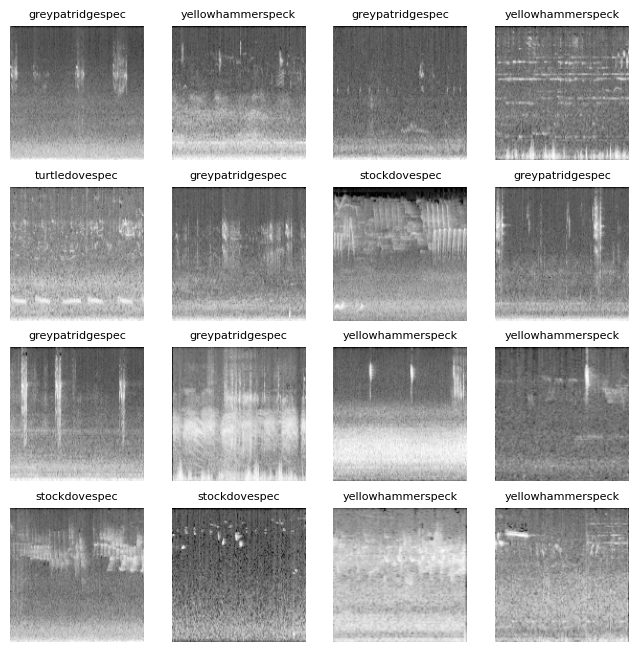

In [422]:

fig,axs = plt.subplots(4,4,figsize=(8,8))
axs = axs.flatten()
for n,ax in enumerate(axs):
    ax.imshow(test_data[n],cmap="Greys")
    ax.set_title(classes[test_label_data[n]],fontsize=8)
    ax.axis('off')

In [423]:
print(train_label_data.size(),train_images_reshaped.size())

torch.Size([3200]) torch.Size([3200, 1, 128, 128])


In [424]:
train_dataset =TensorDataset(train_label_data,train_images_reshaped)
test_dataset =TensorDataset(test_label_data,test_images_reshaped)

batch_size=128

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True) 

#### Q2:  What is the most appropriate model for the problem??

The most appropriate model for the problem is a CNN where we could work over image data. The model used in this problem contains of 3 Convolutional layers and 1 fully connected layer.

In [415]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.4)
            

        )

        self.fc = nn.Sequential(
            nn.Linear(16384, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(True),
            nn.Linear(200, 4),
            # nn.BatchNorm1d(128),
            # nn.LeakyReLU(True),
            # nn.Linear(128, 4),
        )

    def forward(self, x):
        # print(x.shape)
        out = self.cnn(x)
        out= self.fc(out)

        return out
    


cnn= CNN()

x= torch.randn(4,1,128,128)
y=cnn(x)
print(y.shape)

torch.Size([4, 4])


In [425]:
num_epochs = 5
n_pixels = 128*216
num_classes = 4

def train(model,train_loader,test_loader,num_epochs,optimizer):
    criterion = nn.CrossEntropyLoss()
    
    epochs, epoch_loss, epoch_val_loss, epoch_accuracy= [],[],[],[]
    for n in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx,(labels, data) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(data.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
        train_loss = train_loss/(batch_idx+1)
        epoch_loss.append(train_loss)
        model.eval()  
        correct = 0
        total = 0
        loss_list = []
        with torch.no_grad():
            for batch_idx,(labels, data) in enumerate(test_loader):
                outputs = model(data.float())
                loss = criterion(outputs, labels)
                loss_list.append(loss)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += len(labels)
                
        val_loss = np.mean(loss_list)
        epoch_val_loss.append(val_loss)
        accuracy = correct/total  
        epoch_accuracy.append(accuracy*100)
        epochs.append(n+1)
        print(f'{n+1} / {num_epochs}: loss {train_loss:0.03f}, test_loss {val_loss:0.03f}, accuracy {accuracy:0.03f}')
        
    fig,axs = plt.subplots(1,2,figsize=(16,5))
    axs[0].plot(epochs,epoch_loss,label='train')
    axs[0].plot(epochs,epoch_val_loss,label='test')
    axs[0].legend()
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[1].plot(epochs,epoch_accuracy)
    axs[1].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')

In [418]:
def test(model, test_data,loss_fn):
    size = len(test_data.dataset)
    num_batches = len(test_data)
    model.eval()
    test_loss = 0
    correct = 0
    
    label_array = np.zeros(len(test_dataset))
    pred_array = np.zeros(len(test_dataset))
    n=0
    with torch.no_grad():
        for labels,images in test_data:
            pred = model(images.float())
            pred_labels = pred.argmax(1)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred_labels == labels).sum().item()

            for label, prediction in zip(labels, pred_labels):
                
                label_array[n] = label
                pred_array[n] = prediction
                n=n+1
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return label_array, pred_array

1 / 100: loss 0.977, test_loss 1.269, accuracy 0.421
2 / 100: loss 0.598, test_loss 0.978, accuracy 0.580
3 / 100: loss 0.537, test_loss 0.587, accuracy 0.802
4 / 100: loss 0.479, test_loss 0.521, accuracy 0.812
5 / 100: loss 0.440, test_loss 0.533, accuracy 0.809
6 / 100: loss 0.412, test_loss 0.484, accuracy 0.820
7 / 100: loss 0.386, test_loss 0.443, accuracy 0.823
8 / 100: loss 0.366, test_loss 0.455, accuracy 0.824
9 / 100: loss 0.349, test_loss 0.431, accuracy 0.834
10 / 100: loss 0.331, test_loss 0.448, accuracy 0.841
11 / 100: loss 0.326, test_loss 0.429, accuracy 0.844
12 / 100: loss 0.292, test_loss 0.398, accuracy 0.851
13 / 100: loss 0.282, test_loss 0.422, accuracy 0.853
14 / 100: loss 0.275, test_loss 0.386, accuracy 0.849
15 / 100: loss 0.269, test_loss 0.384, accuracy 0.855
16 / 100: loss 0.277, test_loss 0.375, accuracy 0.869
17 / 100: loss 0.249, test_loss 0.389, accuracy 0.860
18 / 100: loss 0.244, test_loss 0.428, accuracy 0.841
19 / 100: loss 0.245, test_loss 0.394

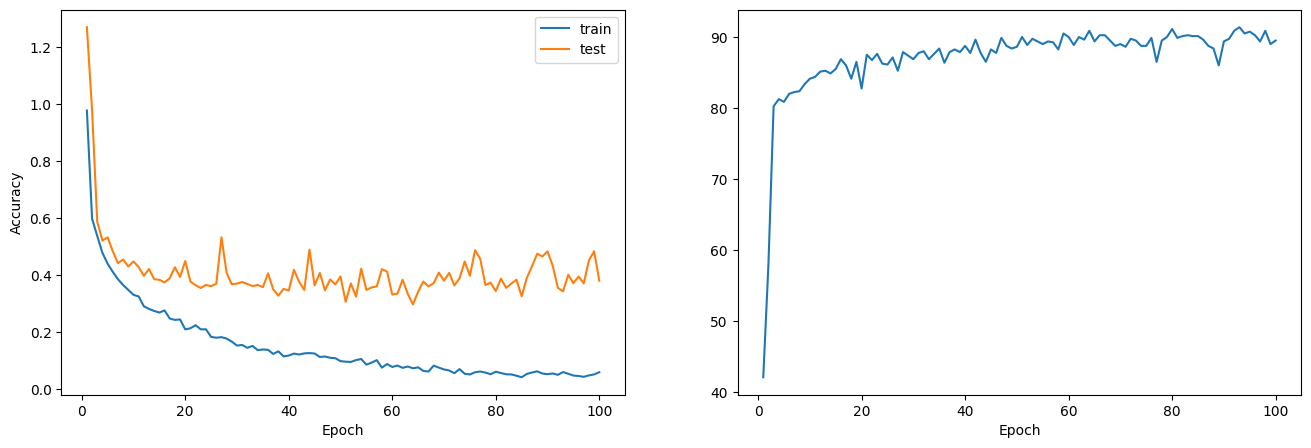

In [433]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)
train(model,train_loader,test_loader,100,optimizer)

print("Done!")

#### Q3: What level of performance is good enough to be useful?

Training the model for 100 epoch we could see that the training and test loss were steadily decreasing. The training loss is decreasing with every epoche and has not saturated suggesting some underfitting. We also observe the test loss is slightly worse than the train loss, which suggest overfitting. Measures have been put in place to reduce over fitting seem to work as the difference is not very large .

In [434]:
n_param = 0
for parameter in model.parameters():
    n_param+=np.prod(parameter.shape)
n_param

3301724

torch.Size([128, 1, 128, 128])


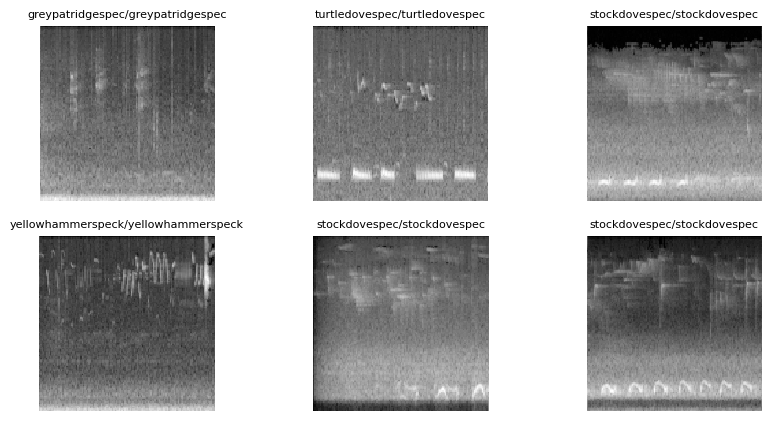

In [436]:
test_enumerator = enumerate(test_loader)
batch_idx, (labels,images) = next(test_enumerator)
# batch_idx, (images, labels) = next(test_enumerator)
print(images.shape)

pred_labels = model(images).argmax(1)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
axs = axs.flatten()
for n, ax in enumerate(axs):
    ax.set_axis_off()
    ax.imshow(images[n][0], cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(classes[pred_labels[n]] + '/' + classes[labels[n]],fontsize=8)

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.417679 



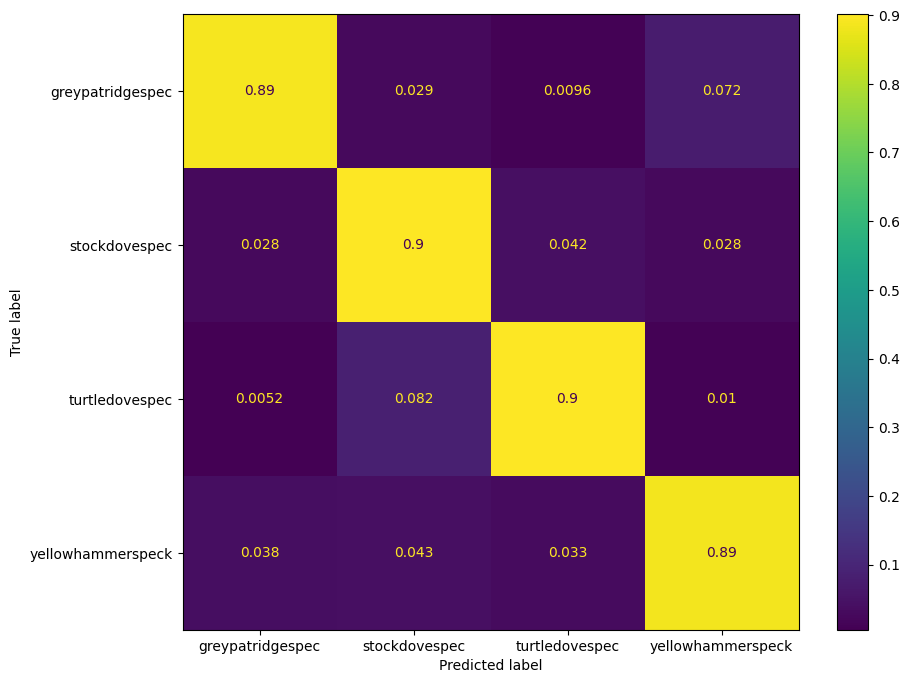

In [437]:
loss_fn=nn.CrossEntropyLoss()
label_array, pred_array = test(model,test_loader,loss_fn)

from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(label_array, pred_array,
                display_labels=classes,
                normalize='true')
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(10)

The confusion matrix and average accuracy suggest we have around 82 % accuracy which seems to be good enough for the model to work as we look over the fit of the curve generated for train and test losses.